# Task 1: Data Preparation

## Imports


In [ ]:
from google.colab import drive
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import random
from scipy.spatial.distance import euclidean
from sklearn.metrics import precision_score, recall_score, homogeneity_score, completeness_score, adjusted_rand_score, silhouette_score




## Directory

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


Base dir exists: True
Train dir exists: True
Val dir exists: True
Test dir exists: True


100%|██████████| 2.29G/2.29G [01:00<00:00, 40.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# Base directory
base_dir = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray'

print(os.listdir(base_dir))

# Define paths for train, val, and test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Validate existence of directories
print(f"Train Directory Exists: {os.path.exists(train_dir)}")
print(f"Validation Directory Exists: {os.path.exists(val_dir)}")
print(f"Test Directory Exists: {os.path.exists(test_dir)}")

['train', 'val', 'chest_xray', '__MACOSX', 'test']
Train Directory Exists: True
Validation Directory Exists: True
Test Directory Exists: True


## Count Images

In [ ]:
# calculate image numbers due to categories
def count_images(directory):
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        category_path = os.path.join(directory, category)
        num_images = len(os.listdir(category_path))
        print(f"{directory.split('/')[-1]} -> {category}: {num_images} images")

# check Train, Validation, Test  sets
print("Training Set:")
count_images(train_dir)

print("\nValidation Set:")
count_images(val_dir)

print("\nTest Set:")
count_images(test_dir)

Training Set:
train -> NORMAL: 1341 images
train -> PNEUMONIA: 3875 images

Validation Set:
val -> NORMAL: 8 images
val -> PNEUMONIA: 8 images

Test Set:
test -> NORMAL: 234 images
test -> PNEUMONIA: 390 images


## Show First Images

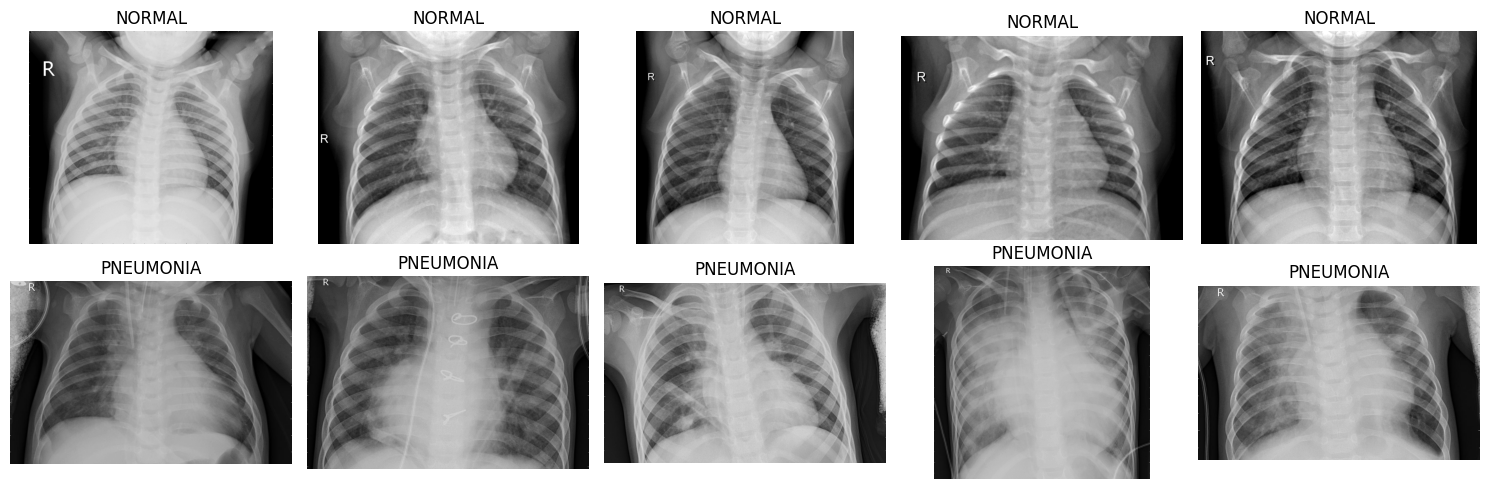

In [ ]:
def show_first_images(train_directory, categories, num_images=5):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 5))

    if len(categories) == 1:
        axes = [axes]

    for row, category in enumerate(categories):
        category_path = os.path.join(train_directory, category)
        images = os.listdir(category_path)[:num_images]

        for col, image_name in enumerate(images):
            image_path = os.path.join(category_path, image_name)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            axes[row][col].imshow(img, cmap='gray')
            axes[row][col].set_title(f"{category}")
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

categories = ['NORMAL', 'PNEUMONIA']



show_first_images(train_dir, categories)

## Load and Flatten Images

In [ ]:
def load_and_flatten_images(directory, categories, img_size=(64, 64)):
    data = []
    labels = []
    for idx, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        for image_name in os.listdir(category_path):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {image_name}")
                continue
            image_path = os.path.join(category_path, image_name)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Skipping corrupted image: {image_path}")
                continue
            img_resized = cv2.resize(img, img_size)
            data.append(img_resized.flatten())
            labels.append(idx)
    return np.array(data), np.array(labels)


categories = ['NORMAL', 'PNEUMONIA']
X_train, train_true_labels = load_and_flatten_images(train_dir, categories)
X_val, val_true_labels = load_and_flatten_images(val_dir, categories)
X_test, test_true_labels = load_and_flatten_images(test_dir, categories)


# Task 2: Dimensionality Reduction

In [ ]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(X_train)
## Before applying reduction methods, we scale our data so that feeatures has unit variances.
##This will help to implement dimesion reduction.
val_features_scaled = scaler.fit_transform(X_val)
## will use for parameter selection on kmeans

test_features_scaled = scaler.fit_transform(X_test)
## will use for evaluation


## PCA


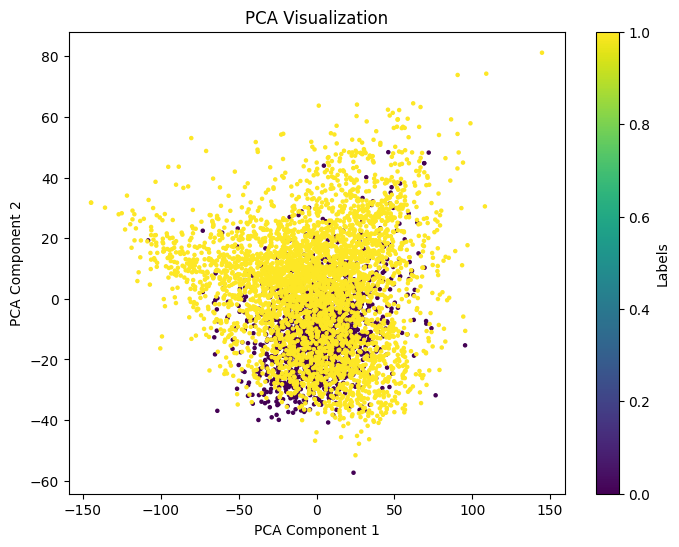

Explained variance on training set: 0.3871286376647592
Explained variance on validation set: 0.3871286376647592
Explained variance on test set: 0.3871286376647592


In [ ]:
pca = PCA(n_components=2)
pca.fit(train_features_scaled)
train_pca = pca.transform(train_features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_true_labels, cmap='viridis', s=5)
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()


print(f"Explained variance on training set: {pca.explained_variance_ratio_.sum()}")

val_pca = pca.transform(val_features_scaled)
print(f"Explained variance on validation set: {pca.explained_variance_ratio_.sum()}")


test_pca = pca.transform(test_features_scaled)
print(f"Explained variance on test set: {pca.explained_variance_ratio_.sum()}")





## t-SNE


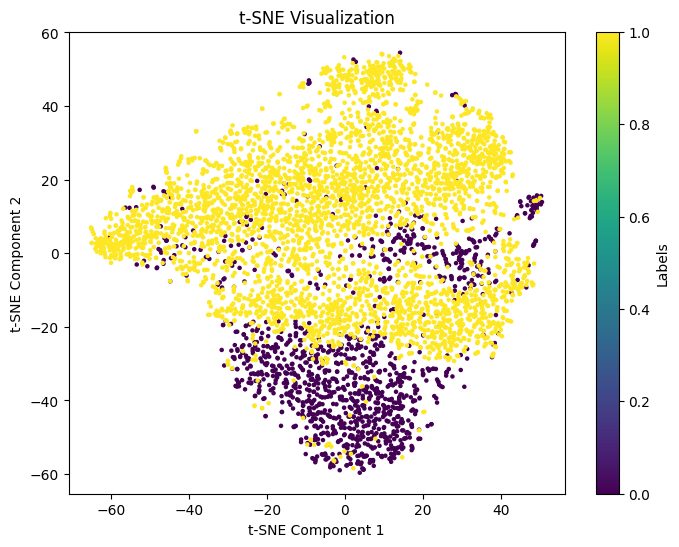

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

train_tsne = tsne.fit_transform(train_features_scaled)

# t-SNE Visualization
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_true_labels, cmap='viridis', s=5)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Labels')
plt.show()

# Task 3: Clustering

## KMeans

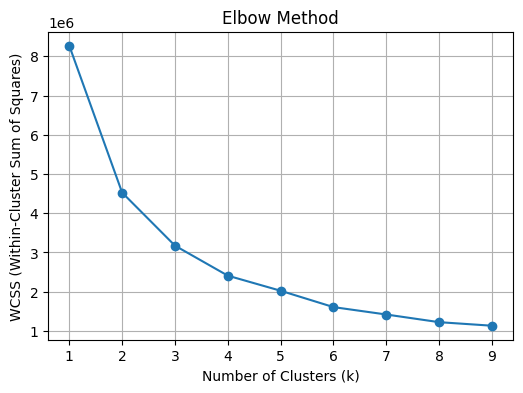

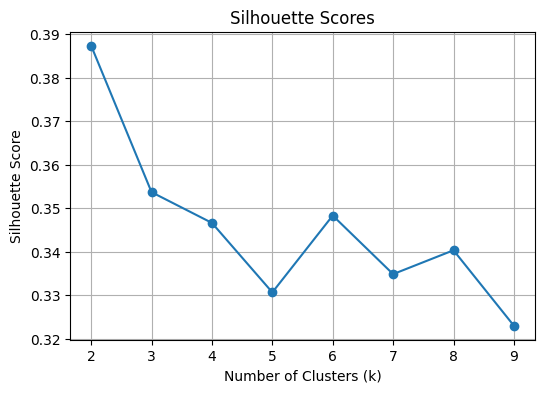

In [ ]:
wcss = []  # List to store within-cluster sum of squares for each k
k_values = range(1, 10)  # Test k values from 1 to 9

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_pca)
    wcss.append(kmeans.inertia_)  # Inertia: WCSS for KMeans

# Plot the Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()

silhouette_scores = []  # List to store silhouette scores for each k
k_values = range(2, 10)  # Silhouette score is not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_pca)
    sil_score = silhouette_score(train_pca, labels)  # Compute Silhouette Score
    silhouette_scores.append(sil_score)

# Plot the Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()







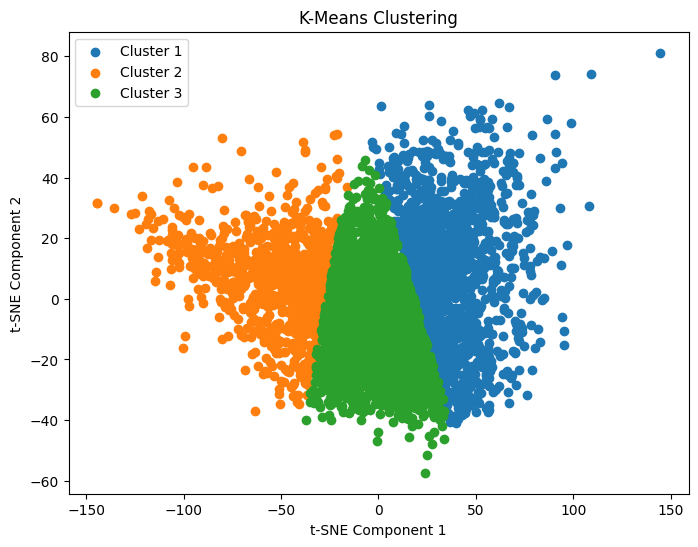

Silhouette score on training set: 0.3537038886172454
Silhouette score on validation set: 0.265941122174905
Silhouette score on test set: 0.33577696868706663


In [ ]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans = kmeans.fit_predict(train_pca)

# show it on combined features
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    plt.scatter(train_pca[labels_kmeans == i, 0], train_pca[labels_kmeans == i, 1], label=f"Cluster {i+1}")
plt.title("K-Means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

val_pca = pca.transform(val_features_scaled)
test_pca = pca.transform(test_features_scaled)


train_silhouette = silhouette_score(train_pca, labels_kmeans)
print(f"Silhouette score on training set: {train_silhouette}")

val_labels = kmeans.predict(val_pca)
val_silhouette = silhouette_score(val_pca, val_labels)
print(f"Silhouette score on validation set: {val_silhouette}")

test_labels = kmeans.predict(test_pca)
test_silhouette = silhouette_score(test_pca, test_labels)
print(f"Silhouette score on test set: {test_silhouette}")





**Discussion for finding the optimal k**
*   **For KMeans**
    * With help of elbow method, we can obsverve the cluster sum of squares(wcss) and with that observation possible candidates for k is 2, 3 and 4.
    * On elbow method we consider really high drop of wcss. After that drop, if next values looks like converge, we can say our possible solution is near that area.
    * With additional help of silhouette score, 2 has the highest score but not always highest score is the best solution. k=2 might leads to underfitting. Aftr testing k=2,3 and 4. Best solution was *k=3*

## Agglomerative Clustering

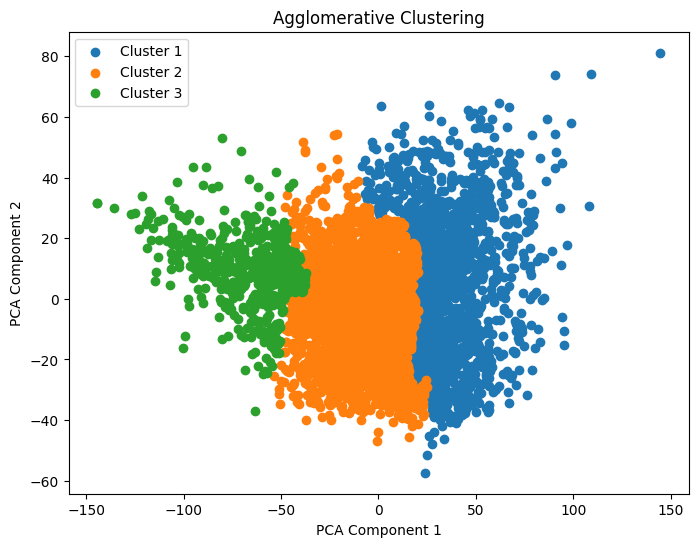

In [ ]:
n_clusters = 3  # Set the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
labels_agg = agg_clustering.fit_predict(train_pca)

# Visualize Agglomerative Clustering Results
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(train_pca[labels_agg == i, 0], train_pca[labels_agg == i, 1], label=f"Cluster {i+1}")
plt.title("Agglomerative Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [ ]:
# Evaluate KMeans clustering
sil_kmeans = silhouette_score(train_pca, labels_kmeans)
hom_kmeans = homogeneity_score(train_true_labels, labels_kmeans)
com_kmeans = completeness_score(train_true_labels, labels_kmeans)
ari_kmeans = adjusted_rand_score(train_true_labels, labels_kmeans)

print(f"KMeans Silhouette Score: {sil_kmeans:.2f}")
print(f"KMeans Homogeneity Score: {hom_kmeans:.2f}")
print(f"KMeans Completeness Score: {com_kmeans:.2f}")
print(f"KMeans ARI: {ari_kmeans:.2f}")

# Evaluate Agglomerative Clustering
sil_agg = silhouette_score(train_pca, labels_agg)
hom_agg = homogeneity_score(train_true_labels, labels_agg)
com_agg = completeness_score(train_true_labels, labels_agg)
ari_agg = adjusted_rand_score(train_true_labels, labels_agg)
print(f"Agglomerative Silhouette Score: {sil_agg:.2f}")
print(f"Agglomerative Homogeneity Score: {hom_agg:.2f}")
print(f"Agglomerative Completeness Score: {com_agg:.2f}")
print(f"Agglomerative ARI: {ari_agg:.2f}")

KMeans Silhouette Score: 0.35
KMeans Homogeneity Score: 0.06
KMeans Completeness Score: 0.04
KMeans ARI: -0.02
Agglomerative Silhouette Score: 0.35
Agglomerative Homogeneity Score: 0.05
Agglomerative Completeness Score: 0.03
Agglomerative ARI: -0.04


## Discussion for 'why choose Aggromerative Clustering and difference between KMeans'
* Note: First we tried DBSCAN but could not optimize epsilon and nearest values because our data was large. Then we tried Aggromative Clustering and it was a bit more understandable for us.

* Unlike KMeans, this method doesn't require predefined k value.
* https://colab.research.google.com/drive/1041HZEKgrahd29BgOf_BNebqoNckeZcu#scrollTo=UoY6lgH3lDPb . With relying on this part, aggromerative uses a dendrogram to visualize the hierarchical  of clusters and select an appropriate level to cut the tree.
* Based on the dendrogram, when n_clusters=3 it provided a good balance between clusters.
* Since we reduced the data to 2 dimensions using PCA for visualization, a significant amount of information was lost. This limits the ability of both Agglomerative Clustering and KMeans to form highly distinct clusters. As a result, there is not much difference in the outcomes of these two methods for this dataset.
* Eventually we can move our tasks with KMeans, which is more simple and will help us to evaluate the query image.

# Task 4: Implement the Query Mechanism

## Select Query Image

In [ ]:
def select_query_image(dir, categories, img_size=(64, 64)):
    ## choose random category from given categories array.
    category = random.choice(categories)
    category_path = os.path.join(dir, category)
    # choose random image with path
    image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_name)
    # resize image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, img_size).flatten()
    # Determine the label based on the selected category
    label = categories.index(category)  # Map category to an integer label (0: NORMAL, 1: PNEUMONIA)
    print(f"Selected Query Image: {image_path}, Label: {label}")
    return img_resized, image_path, label

categories =['NORMAL', "PNEUMONIA"]

image_val, image_val_path, label_val = select_query_image(val_dir, categories)

image_val_scaled = scaler.transform([image_val])  # Scale query image
image_val_pca = pca.transform(image_val_scaled)  # using pca for querying the image. Becase tsne has no power to evaluate new data.

query_image, query_image_path, query_label = select_query_image(test_dir, categories)

query_image_scaled = scaler.transform([query_image])  # Scale query image
query_image_pca = pca.transform(query_image_scaled)  # using pca for querying the image. Becase tsne has no power to evaluate new data.






Selected Query Image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg, Label: 0
Selected Query Image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person134_bacteria_640.jpeg, Label: 1


In [ ]:
query_val_cluster_kmeans = kmeans.predict(image_val_pca)[0]
print(f"Query Image Cluster: {query_val_cluster_kmeans}")

cluster_val_indices_kmeans = [i for i, label in enumerate(labels_kmeans) if label == query_val_cluster_kmeans]
print(f"Indices of Images in the Same Cluster: {cluster_val_indices_kmeans}")

 ## predict image to which cluster with kmeans.
query_cluster_kmeans = kmeans.predict(query_image_pca)[0]
print(f"Query Image Cluster: {query_cluster_kmeans}")

cluster_indices_kmeans = [i for i, label in enumerate(labels_kmeans) if label == query_cluster_kmeans]
print(f"Indices of Images in the Same Cluster: {cluster_indices_kmeans}")





Query Image Cluster: 0
Indices of Images in the Same Cluster: [0, 5, 6, 8, 30, 45, 49, 52, 55, 56, 64, 79, 81, 83, 89, 91, 118, 122, 126, 127, 142, 144, 145, 153, 158, 176, 180, 188, 190, 191, 200, 204, 206, 209, 217, 219, 221, 222, 223, 240, 243, 249, 256, 261, 276, 277, 280, 292, 299, 305, 321, 326, 329, 330, 336, 337, 338, 346, 347, 349, 356, 357, 360, 366, 372, 387, 390, 391, 392, 397, 401, 406, 414, 417, 427, 437, 438, 450, 472, 478, 481, 487, 493, 501, 514, 522, 523, 527, 531, 532, 535, 538, 539, 543, 547, 549, 553, 560, 564, 567, 571, 577, 578, 579, 588, 590, 593, 600, 601, 602, 604, 606, 623, 627, 628, 629, 630, 641, 644, 646, 652, 654, 659, 673, 681, 702, 706, 708, 710, 711, 714, 715, 730, 734, 736, 739, 742, 746, 761, 766, 767, 769, 776, 778, 784, 792, 802, 804, 806, 820, 827, 832, 840, 841, 843, 847, 852, 861, 874, 875, 878, 891, 892, 895, 913, 914, 915, 916, 919, 923, 924, 931, 939, 942, 945, 954, 959, 963, 966, 980, 989, 998, 1009, 1013, 1033, 1035, 1037, 1038, 1047, 1048,

## Distances

In [ ]:
## computing distances of each data to given query
distances_kmeans = []
for i in cluster_indices_kmeans:
    distance = euclidean(query_image_pca.flatten(), train_pca[i])
    distances_kmeans.append((i, distance))

distances_val_kmeans = []
for i in cluster_indices_kmeans:
    distance = euclidean(image_val_pca.flatten(), train_pca[i])
    distances_val_kmeans.append((i, distance))

top_3_similar_val_kmeans = sorted(distances_val_kmeans, key=lambda x: x[1])[:3]
print("Top 3 similar images for val (indices and distances):", top_3_similar_val_kmeans)

## sorting distances and getting top 3 with [:3]
top_3_similar_kmeans = sorted(distances_kmeans, key=lambda x: x[1])[:3]
print("Top 3 similar images (indices and distances):", top_3_similar_kmeans)


Top 3 similar images for val (indices and distances): [(598, 22.903255416712945), (1776, 23.01749024415119), (335, 23.029462606587924)]
Top 3 similar images (indices and distances): [(134, 0.5142310971810039), (1380, 0.5266901146302729), (4356, 1.0090636265683741)]


## Display Query and 3 Similar Images

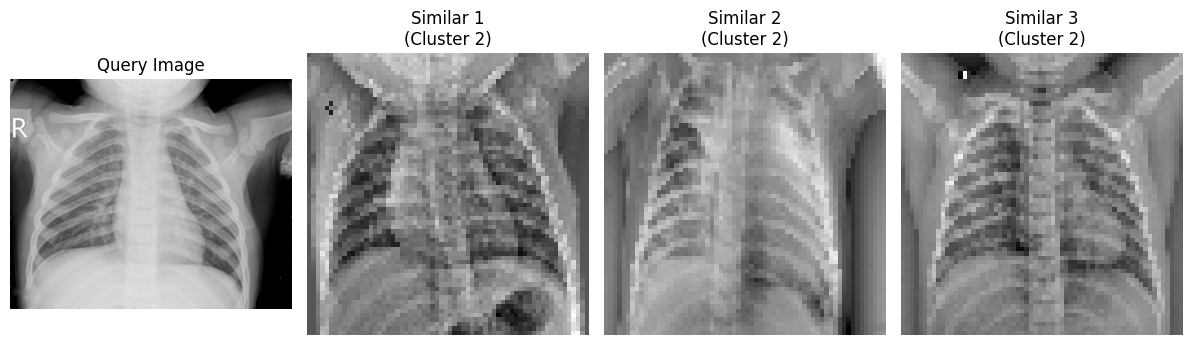

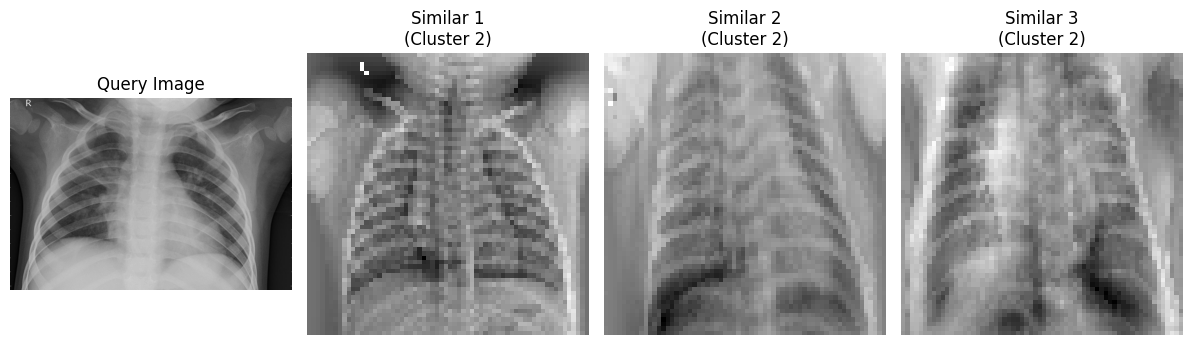

In [ ]:
def display_query_and_similar(query_image_path, similar_indices, data, labels):
    plt.figure(figsize=(15, 5))
    ## for white background


    plt.subplot(1, 5, 1)
    query_img = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(query_img, cmap='gray')
    plt.title("Query Image")
    plt.axis('off')

    for i, (idx, distance) in enumerate(similar_indices):
        plt.subplot(1, 5, i + 2)
        similar_img = data[idx].reshape(64, 64)
        plt.imshow(similar_img, cmap='gray')
        plt.title(f"Similar {i+1}\n(Cluster {labels[idx]})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


display_query_and_similar(image_val_path, top_3_similar_val_kmeans,train_features_scaled, labels_kmeans)

display_query_and_similar(query_image_path, top_3_similar_kmeans, train_features_scaled, labels_kmeans)





# Task 5: Evaluate Clustering and Query-Based Performance

## Evaluate Cluster Performance

In [ ]:
def evaluate_cluster_performance(true_labels, predicted_labels):

    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)

    metrics = {
        "Homogeneity": homogeneity,
        "Completeness": completeness
    }
    return metrics


## Evaluate Query Performance

In [ ]:
def evaluate_query_performance(query_label, similar_indices, true_labels):

    retrieved_labels = [true_labels[i] for i, _ in similar_indices]
    relevant_retrieved = sum(1 for label in retrieved_labels if label == query_label)
    total_relevant = sum(1 for label in true_labels if label == query_label)

    # calculate with @3
    precision = relevant_retrieved / 3
    recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
    return precision, recall, relevant_retrieved, total_relevant


## Metrics

In [ ]:
cluster_metrics_kmeans = evaluate_cluster_performance(train_true_labels, labels_kmeans)
print(" Metrics for KMeans ")
for metric, value in cluster_metrics_kmeans.items():
    print(f"{metric}: {value}")

 Metrics for KMeans 
Homogeneity: 0.06292426001599012
Completeness: 0.03551063358934103


In [ ]:
precision_kmeans, recall_kmeans, relevant_retrieved_kmeans, total_relevant_kmeans = evaluate_query_performance(query_label, top_3_similar_kmeans, train_true_labels)
print(f"Precision@3: {precision_kmeans:.2f}")
print(f"Recall@3: {recall_kmeans:.4f}")


Precision@3: 0.67
Recall@3: 0.0005


**Discussion about metrics**

* **Cluster Metrics:**
    * *Homogenity:* Measures how well each cluster contains true labels.
      * Homogenity score is low. Because we think after using PCA with 2 components, we lost really important informations. Thus this shows that bad alignment between true labels and clusters.
    * *Completeness:* Measures whether all data points of a single label assigned to the same cluster.
      * Completeness score shows that clusters don't indicate true labels properly.

**Conclusion of Cluster Metrics**
* These metrics show us that our clustering didn't approporiate. In the homework it says, do dimension reduction on 2D. So we lost so much information while that transformation. The variance of the data is not suitable to directly reduce to 2D. If we use closely 30 40 components we would get higher scores.




* **Query Performance**
    * *Precision@3:* Out of the top 3 retrieved images based on similarity in our case, how many match the true label of query image.
      * As we know we are selecting the query image with random function, sometimes we get precision score 1.00 sometimes 0.33. But we mentioned before, we lost important features so this is normal to get precision 1 or 0.33. which is 3/3 or 1/3.
    * *Recall@3:* Our recall is really low in all cases, becase what we retrive from clusters are really high values compare to what we need. Which is relevant/retrieved.

**Conclusion of Query Performance**
* Query performance changes related to random function. But we calculating the distance correctly so we always get the closest images. But it doesn't say that we retrieve the correct images.

# Final Conclusion

* We decreased the dimension directly to 2D. We lost so much information and that's why our some clusters overlapped. We calculated the variance after PCA with validation and test datasets and we get ~%38. KMeans helps us to seperate that overlapping but that was not enough for our dataset. We also used validation dataset and test dataset with using silhouette score. Normally we get more decreased values but not that much. train was ~%35, validation was ~%27 test was ~%33. Eventually if we increase the PCA components, we would get higher scores.